# Examination of Inside AIRBNB data for Seattle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from folium import FeatureGroup, LayerControl, Map, vector_layers
from scipy.optimize import curve_fit
#from mpl_toolkits.basemap import Basemap
#Uncomment the above line if there are no issues with the 'Proj_Lib' environment variable
import matplotlib as mpl

In [2]:
# Only run this cell if 'PROJ_LIB' (needed by Basemap) is not on the path
# The directory will be the location on the hard drive for 'epsg.*'
# https://stackoverflow.com/questions/52911232/basemap-library-using-anaconda-jupyter-notebooks-keyerror-proj-lib/54087410#54087410
# Pavlo's answer
import os
os.environ['PROJ_LIB'] = r'.conda\pkgs\proj4-5.2.0-ha925a31_1\library\share'
from mpl_toolkits.basemap import Basemap

Read in listings and convert price to numeric value.

In [3]:
listings = pd.read_csv('listings.csv', low_memory=False)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20190209052057,2019-02-09,Casa Madrona -Urban Oasis! *Discount all of Feb*!,"Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, (Phone number h...",none,Madrona is a hidden gem of a neighborhood. It ...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.17
1,4291,https://www.airbnb.com/rooms/4291,20190209052057,2019-02-09,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,...,f,f,moderate,f,f,5,1,4,0,0.92
2,5682,https://www.airbnb.com/rooms/5682,20190209052057,2019-02-09,"Cozy Studio, min. to downtown -WiFi",The Cozy Studio is a perfect launchpad for you...,"Hello fellow travelers, Save some money and ha...",The Cozy Studio is a perfect launchpad for you...,none,NaN,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,4.27
3,6606,https://www.airbnb.com/rooms/6606,20190209052057,2019-02-09,"Fab, private seattle urban cottage!",NaN,"Soo centrally located, this is a little house ...","Soo centrally located, this is a little house ...",none,"A peaceful yet highly accessible neighborhood,...",...,f,f,strict_14_with_grace_period,f,f,3,3,0,0,1.15
4,9419,https://www.airbnb.com/rooms/9419,20190209052057,2019-02-09,Glorious sun room w/ memory foambed,This beautiful double room features a magical ...,Our new Sunny space has a private room from th...,This beautiful double room features a magical ...,none,"Lots of restaurants (see our guide book) bars,...",...,f,f,moderate,t,t,7,0,7,0,1.26


In [4]:
listings.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [5]:
# convert price to numerical value
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

### This section relates to examine the data in relation to the law passed in Seattle restricting the numer of units per host. This also examines when and where rental units were add and if there is any apparent correlations of price and area.

In [6]:
a = 2008
to_plot_t = 0
yearly = []
cumlative = []
colors = ('black','red','green','blue','purple','gray','pink','lightgreen','cadetblue','darkred','darkblue')
m = Map(location=[47.615, -122.33],zoom_start=11,width='45%',height='75%',prefer_canvas=True)
for i in range(0,11):
    comp_date_u = '{}-12-31'.format(a+int(i))
    comp_date_l = '{}-01-01'.format(a+int(i))
    upper = listings['host_since']<=comp_date_u
    lower = listings['host_since']>=comp_date_l
    to_plot = listings['id'].loc[upper & lower].index.values
    to_plot_len = len(to_plot)
    to_plot_t += to_plot_len
    yearly.append(to_plot_len)
    cumlative.append(to_plot_t)
    name_lc = "<span style='color: {}'>{} {:4d} {:4d}</span>".format(colors[i],comp_date_u,to_plot_len,to_plot_t)
    #feature_group = FeatureGroup(name=comp_date+' '+name_add,show=False)
    feature_group = FeatureGroup(name=name_lc,show=False)
    
    for j in to_plot:
        vector_layers.Circle(
            radius=1,
            location=[listings['latitude'].loc[j],listings['longitude'].loc[j]],
            color=colors[i],
            fill=False,
        ).add_to(feature_group) 
        feature_group.add_to(m)

LayerControl().add_to(m)
fname = r'Figures\SeattleABB_map.html'
m.save(fname, close_file=False)

In [7]:
under_2 = listings['calculated_host_listings_count']<=2
over_5 = listings['calculated_host_listings_count']>=5
m = Map(location=[47.615, -122.33],zoom_start=11,width='45%',height='75%',prefer_canvas=True)
feature_group = FeatureGroup(name='Under 2',show=False)
for j in listings['id'].loc[under_2].index.values:
    vector_layers.Circle(
            radius=1,
            location=[listings['latitude'].loc[j],listings['longitude'].loc[j]],
            color='black',
            fill=False,
        ).add_to(feature_group) 
    feature_group.add_to(m)
feature_group = FeatureGroup(name='3 to 5',show=False)
for j in listings['id'].loc[~under_2 & ~over_5].index.values:
    vector_layers.Circle(
            radius=1,
            location=[listings['latitude'].loc[j],listings['longitude'].loc[j]],
            color='blue',
            fill=False,
        ).add_to(feature_group) 
    feature_group.add_to(m)    
feature_group = FeatureGroup(name='Over 5',show=False)
for j in listings['id'].loc[over_5].index.values:
    vector_layers.Circle(
            radius=1,
            location=[listings['latitude'].loc[j],listings['longitude'].loc[j]],
            color='red',
            fill=False,
        ).add_to(feature_group) 
    feature_group.add_to(m)    
LayerControl().add_to(m)
fname = r'Figures\SeattleABB_map_units.html'
m.save(fname, close_file=False)

In [8]:
def sigmoid(x, a, b, c):
     y = a / (1 + 10**((b-x)*c))
     return y

popt, pcov = curve_fit(sigmoid, 2008+np.arange(0,11), cumlative, p0=[8810,2014,0.5])
y = sigmoid(2008+np.arange(0,11),*popt)

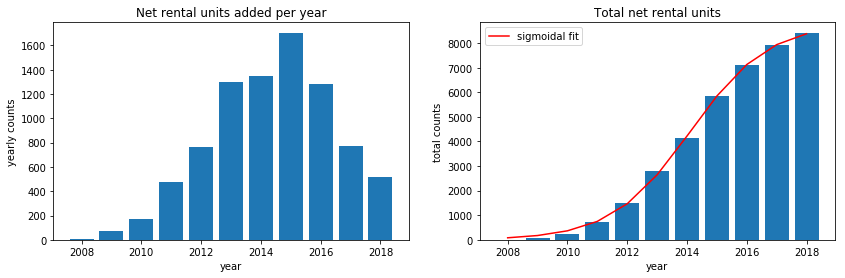

In [9]:
fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].bar(2008+np.arange(0,11),yearly)
axs[0].set_xlabel('year')
axs[0].set_ylabel('yearly counts')
axs[0].set_title('Net rental units added per year')

axs[1].bar(2008+np.arange(0,11),cumlative)
axs[1].plot(2008+np.arange(0,11),y,'red',label='sigmoidal fit')
axs[1].set_xlabel('year')
axs[1].set_ylabel('total counts')
axs[1].set_title('Total net rental units');
axs[1].legend();

fig.savefig(r'Figures\unitsadded.png')

In [10]:
listings['host_listings_count'].loc[listings['host_listings_count']==1].count()

3963

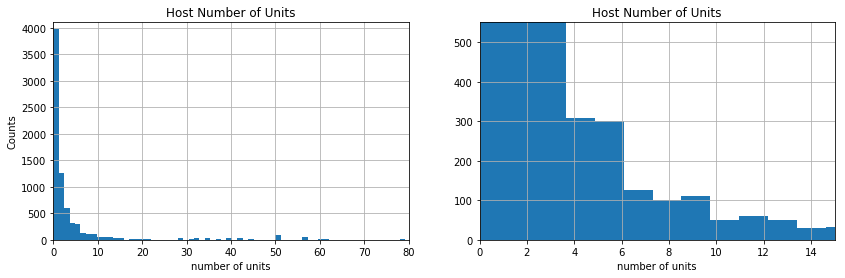

In [11]:
fig, axs = plt.subplots(1,2,figsize=(14,4))

listings['host_listings_count'].hist(bins=1310,ax=axs[0])
axs[0].axis([0, 80, 0, 4100])
axs[0].set_xlabel('number of units')
axs[0].set_ylabel('Counts')
axs[0].set_title('Host Number of Units');

listings['host_listings_count'].hist(bins=1310,ax=axs[1])
axs[1].axis([0, 15, 0, 550])
axs[1].set_xlabel('number of units')
axs[1].set_title('Host Number of Units');

fig.savefig(r'Figures\no_units.png')

Conclusions: There is no apparent correlation in rental price with location. There are a significant number of hosts with more than 2 units.

### This section examines several criteria for how the hosts are using the housing units. This relates to availibity for in city living versus short term tourist rentals. The main criteria for whether it makes sense for the owner to turn a long term housing unit into a short term rental is price and occupancy. Occupancy is the most difficult criteria to measure from the Inside AIRBNB data.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


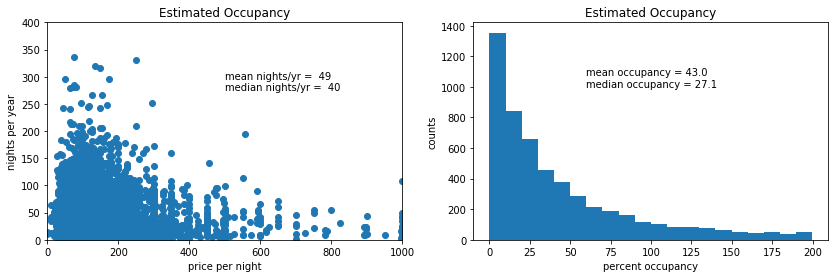

In [12]:
nights_per_year = 12 * listings['reviews_per_month'].values * listings['minimum_nights'].values
occupancy = nights_per_year / listings['availability_365'] * 100
# filter out obviously biased data
# this highlights the issue of not using direct measures of occupancy
occ_out = occupancy < 200
nights_out = nights_per_year < 365
comb_out = occ_out & nights_out

fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].plot(listings['price'].loc[comb_out],nights_per_year[comb_out],'o')
axs[0].axis([0, 1000, 0, 400])
axs[0].set_xlabel('price per night')
axs[0].set_ylabel('nights per year')
axs[0].set_title('Estimated Occupancy');
axs[0].text(500,275,
            'mean nights/yr = {:3.0f}\nmedian nights/yr = {:3.0f}'.format(np.mean(nights_per_year[comb_out]),np.median(nights_per_year[comb_out])));

axs[1].hist(occupancy[comb_out],bins=20)
axs[1].set_xlabel('percent occupancy')
axs[1].set_ylabel('counts')
axs[1].set_title('Estimated Occupancy')
axs[1].text(60,1000,
         'mean occupancy = {:2.1f}\nmedian occupancy = {:2.1f}'.format(occupancy[comb_out].mean(),occupancy[comb_out].median()));

fig.savefig(r'Figures\occupancy.png')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


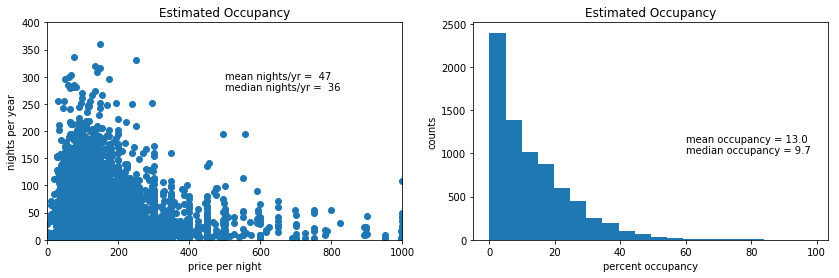

In [13]:
nights_per_year = 12 * listings['reviews_per_month'].values * listings['minimum_nights'].values
occupancy = nights_per_year / 365 * 100
# filter out obviously biased data
# this highlights the issue of not using direct measures of occupancy
occ_out = occupancy < 200
nights_out = nights_per_year < 365
comb_out = occ_out & nights_out

fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].plot(listings['price'].loc[comb_out],nights_per_year[comb_out],'o')
axs[0].axis([0, 1000, 0, 400])
axs[0].set_xlabel('price per night')
axs[0].set_ylabel('nights per year')
axs[0].set_title('Estimated Occupancy');
axs[0].text(500,275,
            'mean nights/yr = {:3.0f}\nmedian nights/yr = {:3.0f}'.format(np.mean(nights_per_year[comb_out]),np.median(nights_per_year[comb_out])));

axs[1].hist(occupancy[comb_out],bins=20)
axs[1].set_xlabel('percent occupancy')
axs[1].set_ylabel('counts')
axs[1].set_title('Estimated Occupancy')
axs[1].text(60,1000,
         'mean occupancy = {:2.1f}\nmedian occupancy = {:2.1f}'.format(np.mean(occupancy[comb_out]),np.median(occupancy[comb_out])));

fig.savefig(r'Figures\occupancy_365.png')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


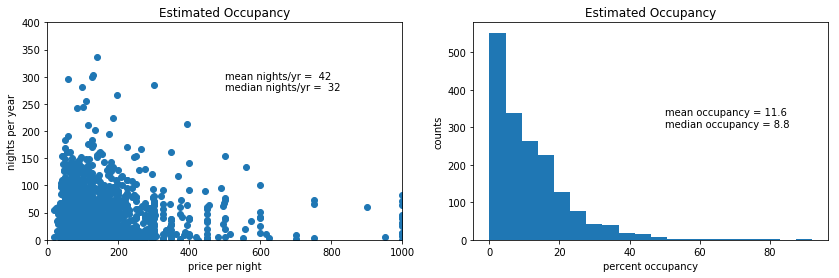

In [14]:
nights_per_year = 12 * listings[listings['room_type']=='Private room']['reviews_per_month'].values * listings[listings['room_type']=='Private room']['minimum_nights'].values
occupancy = nights_per_year / 365 * 100
# filter out obviously biased data
# this highlights the issue of not using direct measures of occupancy
occ_out = occupancy < 200
nights_out = nights_per_year < 365
comb_out = occ_out & nights_out

fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].plot(listings['price'].loc[comb_out],nights_per_year[comb_out],'o')
axs[0].axis([0, 1000, 0, 400])
axs[0].set_xlabel('price per night')
axs[0].set_ylabel('nights per year')
axs[0].set_title('Estimated Occupancy');
axs[0].text(500,275,
            'mean nights/yr = {:3.0f}\nmedian nights/yr = {:3.0f}'.format(np.mean(nights_per_year[comb_out]),np.median(nights_per_year[comb_out])));

axs[1].hist(occupancy[comb_out],bins=20)
axs[1].set_xlabel('percent occupancy')
axs[1].set_ylabel('counts')
axs[1].set_title('Estimated Occupancy')
axs[1].text(50,300,
         'mean occupancy = {:2.1f}\nmedian occupancy = {:2.1f}'.format(np.mean(occupancy[comb_out]),np.median(occupancy[comb_out])));

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


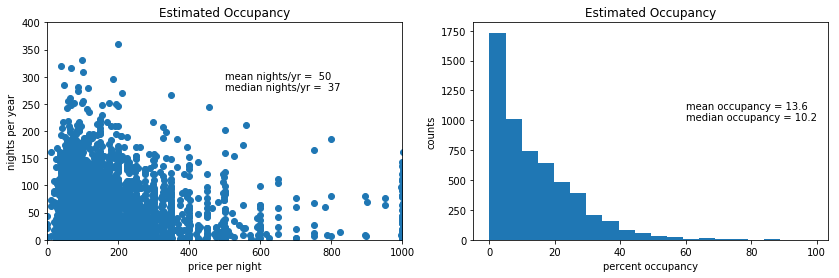

In [15]:
nights_per_year = 12 * listings[listings['room_type']=='Entire home/apt']['reviews_per_month'].values * listings[listings['room_type']=='Entire home/apt']['minimum_nights'].values
occupancy = nights_per_year / 365 * 100
# filter out obviously biased data
# this highlights the issue of not using direct measures of occupancy
occ_out = occupancy < 200
nights_out = nights_per_year < 365
comb_out = occ_out & nights_out

fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].plot(listings['price'].loc[comb_out],nights_per_year[comb_out],'o')
axs[0].axis([0, 1000, 0, 400])
axs[0].set_xlabel('price per night')
axs[0].set_ylabel('nights per year')
axs[0].set_title('Estimated Occupancy');
axs[0].text(500,275,
            'mean nights/yr = {:3.0f}\nmedian nights/yr = {:3.0f}'.format(np.mean(nights_per_year[comb_out]),np.median(nights_per_year[comb_out])));

axs[1].hist(occupancy[comb_out],bins=20)
axs[1].set_xlabel('percent occupancy')
axs[1].set_ylabel('counts')
axs[1].set_title('Estimated Occupancy')
axs[1].text(60,1000,
         'mean occupancy = {:2.1f}\nmedian occupancy = {:2.1f}'.format(np.mean(occupancy[comb_out]),np.median(occupancy[comb_out])));

In [16]:
reviews = pd.read_csv('reviews.csv', low_memory=False)
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


In [18]:
first = reviews['date']>='2018-01-01'
last = reviews['date']<'2019-01-01'
reviews_2018 = reviews[first & last]
reviews_2018_count = reviews_2018.groupby('listing_id').count()
reviews_2018_count.head()

,id,date,reviewer_id,reviewer_name,comments
listing_id,,,,,
2318,10,10,10,10,10
4291,9,9,9,9,9
5682,54,54,54,54,54
6606,26,26,26,26,26
9419,14,14,14,14,14


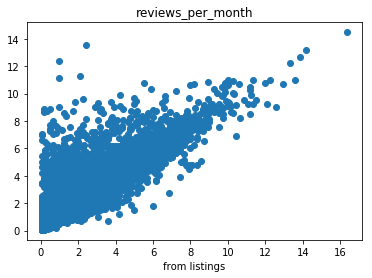

In [19]:
x = reviews_2018_count['id']/12
y = listings[listings['id'].isin(reviews_2018_count.index.tolist())]['reviews_per_month'].values
plt.plot(x,y,'o')
plt.xlabel('using current reviews')
plt.xlabel('from listings')
plt.title('reviews_per_month');

There is some discrepancy for the number of reviews from the listings and calculated from the number of reviews over the last year.

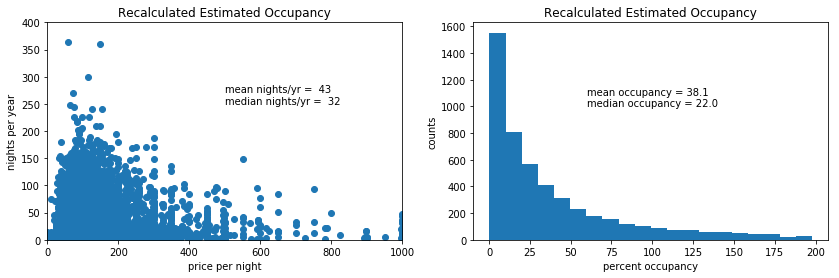

In [20]:
# replace the reviews per month with the reviews for 2018 from the reviews file (more recent)
nights_per_year = reviews_2018_count['id'].values * listings[listings['id'].isin(reviews_2018_count.index.tolist())]['minimum_nights'].values
occupancy = nights_per_year / listings[listings['id'].isin(reviews_2018_count.index.tolist())]['availability_365'] * 100
# filter out obviously biased data
# this highlights the issue of not using direct measures of occupancy
occ_out = occupancy < 200
nights_out = nights_per_year < 365
comb_out = occ_out & nights_out

fig, axs = plt.subplots(1,2,figsize=(14,4))

axs[0].plot(listings[listings['id'].isin(reviews_2018_count.index.tolist())]['price'].loc[comb_out],nights_per_year[comb_out],'o')
axs[0].axis([0, 1000, 0, 400])
axs[0].set_xlabel('price per night')
axs[0].set_ylabel('nights per year')
axs[0].set_title('Recalculated Estimated Occupancy');
axs[0].text(500,250,
            'mean nights/yr = {:3.0f}\nmedian nights/yr = {:3.0f}'.format(np.mean(nights_per_year[comb_out]),np.median(nights_per_year[comb_out])));

axs[1].hist(occupancy[comb_out],bins=20)
axs[1].set_xlabel('percent occupancy')
axs[1].set_ylabel('counts')
axs[1].set_title('Recalculated Estimated Occupancy')
axs[1].text(60,1000,
         'mean occupancy = {:2.1f}\nmedian occupancy = {:2.1f}'.format(occupancy[comb_out].mean(),occupancy[comb_out].median()));

fig.savefig(r'Figures\occupancy_1.png')

There is a shift in mean occupancy and the nights per year at each host, but there is still occupancy higher than 100%.

In [21]:
room_type = listings.groupby(['room_type','property_type'])['id'].count()
room_df = pd.merge(room_type['Entire home/apt'].to_frame(),room_type['Private room'].to_frame(),
                   how='outer',on='property_type',suffixes=('_Entire','_Partial'))
room_df

,id_Entire,id_Partial
property_type,,
Apartment,2567.0,218.0
Bed and breakfast,2.0,17.0
Boat,18.0,3.0
Boutique hotel,1.0,2.0
Bungalow,67.0,29.0
Cabin,19.0,3.0
Camper/RV,18.0,1.0
Chalet,1.0,NaN
Condominium,426.0,49.0


There are a significant number of apartments that are being using a short term rental units.

### This section examines whether the data can be used to set a starting rental price for a new host. It will utilize different regression models using a limited amount of data.

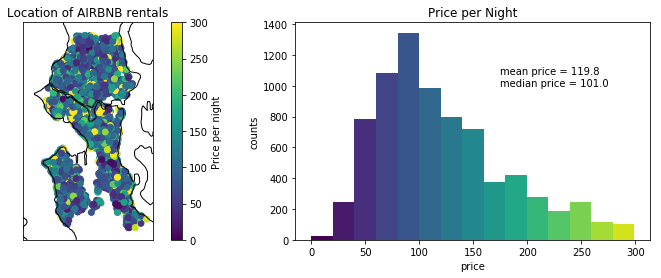

In [22]:
# for faster execution set resolution to 'l'.

fig = plt.figure(figsize=(14,4))

ax = fig.add_subplot(1,2,1)
ax.set_title('Location of AIRBNB rentals')
m = Basemap(projection='merc', resolution='f',
            llcrnrlon=-122.46,llcrnrlat=47.481,urcrnrlon=-122.22,urcrnrlat=47.75,
            lat_0=47.6, lon_0=-122.3,)
m.drawcoastlines()
m.scatter(listings['longitude'].values, listings['latitude'].values, 
          latlon=True, c=listings['price'].values, cmap='viridis', vmin=0, vmax=300)
cbar = plt.colorbar()
cbar.set_label('Price per night')


ax = fig.add_subplot(1,2,2)

price = listings['price'].values
N, bins_o, patches = ax.hist(price[price<300], bins=15)
norm = mpl.colors.Normalize(0, 300)
for thisbin, thispatch in zip(bins_o, patches):
    color = plt.cm.viridis(norm(thisbin))
    thispatch.set_facecolor(color)
ax.set_xlabel('price')
ax.set_ylabel('counts')
ax.set_title('Price per Night')
ax.text(175,1000,
         'mean price = {:2.1f}\nmedian price = {:2.1f}'.format(np.mean(price[price<300]),np.median(price[price<300])));


fig.savefig(r'Figures\price.png')

In [23]:
num_of_units = 2  # this is part of the restriction of the new law
scaler = StandardScaler()
listings_to_use = ['host_is_superhost','latitude','longitude','property_type','room_type',
                   'accommodates','bathrooms','bedrooms','beds','minimum_nights']
x_data = listings[listings_to_use].loc[listings['host_listings_count']<=num_of_units]
numerical_listings = ['latitude','longitude','accommodates','bathrooms','bedrooms','beds','minimum_nights']
x_data_mean = pd.DataFrame(data = x_data)
x_data_mean[numerical_listings] = scaler.fit_transform(x_data[numerical_listings])
x_data_f = pd.get_dummies(x_data_mean, prefix=['superhost', 'property', 'room'])

y_data = listings['price'].loc[listings['host_listings_count']<=num_of_units]
x_data_f.fillna(x_data_f.mean(), inplace=True)
x_data_f.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,superhost_f,superhost_t,property_Apartment,...,property_Serviced apartment,property_Tent,property_Tiny house,property_Townhouse,property_Treehouse,property_Villa,property_Yurt,room_Entire home/apt,room_Private room,room_Shared room
0,-0.343376,1.253844,2.179086,2.136316,2.583484,1.638401,0.245194,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,-2.059617,-0.699926,-0.755175,-0.464201,-1.417070,-0.688591,-0.038157,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,-1.438856,-1.402750,0.222912,-0.464201,0.583207,2.414065,-0.108995,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,-1.422129,-1.437877,-0.266131,-0.464201,0.583207,0.087073,-0.108995,1,0,0,...,0,0,0,0,0,0,0,1,0,0
10,-1.473315,-0.795153,-1.244218,0.402638,-1.417070,-0.688591,0.103519,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
x_data_f.fillna(x_data_f.mean(), inplace=True)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x_data_f, 
                                                    y_data, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

Mean squared error: 15428.3 5205.9
Variance: 0.2756 0.4423


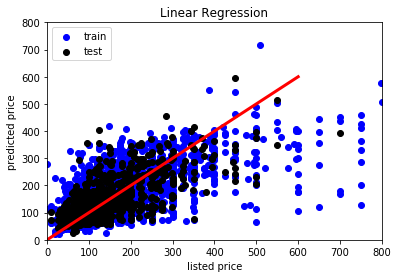

In [26]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_train = regr.predict(X_train)
predictions_test = regr.predict(X_test)

print('Mean squared error: {:.1f} {:.1f}'.format(
      mean_squared_error(y_train, predictions_train),
      mean_squared_error(y_test, predictions_test)))

print('Variance: {:.4f} {:.4f}'.format(
      r2_score(y_train, predictions_train),
      r2_score(y_test, predictions_test)))

# Plot outputs

plt.scatter(y_train, predictions_train, color='blue', label='train')
plt.scatter(y_test, predictions_test,  color='black', label='test')
plt.plot([0,600],[0,600], color='red', linewidth=3)
plt.axis([0, 800, 0, 800])
plt.xlabel('listed price')
plt.ylabel('predicted price')
plt.title('Linear Regression')
plt.legend(loc=2)

plt.savefig(r'Figures\linear.png')

plt.show();

Mean squared error: 5559.7 5060.5
Variance: 0.7389 0.4579


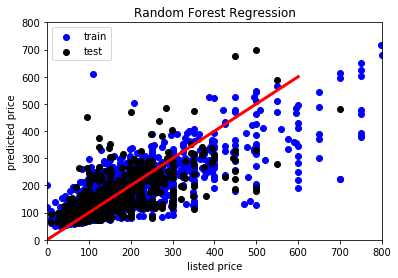

In [27]:
regr = RandomForestRegressor(max_depth=10, max_features=5, n_estimators=1000, random_state=42)
regr.fit(X_train,y_train)

predictions_train = regr.predict(X_train)
predictions_test = regr.predict(X_test)

print('Mean squared error: {:.1f} {:.1f}'.format(
      mean_squared_error(y_train, predictions_train),
      mean_squared_error(y_test, predictions_test)))

print('Variance: {:.4f} {:.4f}'.format(
      r2_score(y_train, predictions_train),
      r2_score(y_test, predictions_test)))

# Plot outputs

plt.scatter(y_train, predictions_train, color='blue', label='train')
plt.scatter(y_test, predictions_test,  color='black', label='test')
plt.plot([0,600],[0,600], color='red', linewidth=3)
plt.axis([0, 800, 0, 800])
plt.xlabel('listed price')
plt.ylabel('predicted price')
plt.title('Random Forest Regression')
plt.legend(loc=2)

plt.savefig(r'Figures\randfor.png')

plt.show();

Mean squared error: 11801.9 5049.0
Variance: 0.4458 0.4591


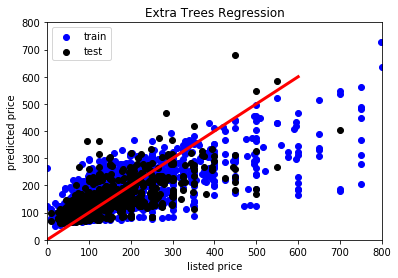

In [28]:
regr = ExtraTreesRegressor(max_depth=10, max_features=5, n_estimators=1000, random_state=42)
regr.fit(X_train,y_train)

predictions_train = regr.predict(X_train)
predictions_test = regr.predict(X_test)

print('Mean squared error: {:.1f} {:.1f}'.format(
      mean_squared_error(y_train, predictions_train),
      mean_squared_error(y_test, predictions_test)))

print('Variance: {:.4f} {:.4f}'.format(
      r2_score(y_train, predictions_train),
      r2_score(y_test, predictions_test)))

# Plot outputs

plt.scatter(y_train, predictions_train, color='blue', label='train')
plt.scatter(y_test, predictions_test,  color='black', label='test')
plt.plot([0,600],[0,600], color='red', linewidth=3)
plt.axis([0, 800, 0, 800])
plt.xlabel('listed price')
plt.ylabel('predicted price')
plt.title('Extra Trees Regression')
plt.legend(loc=2)

plt.savefig(r'Figures\extratrees.png')

plt.show();

All three methods yielded similar profiles. The Random Forest is the best fit on the training set, while all three are comparable on the testing set. The ExtraTrees method exhibits slightly smaller variance at the lower prices, so that would be the first choice to proceed with. The low correlations are most likely related to the hosts being able to set the price and does not take into account what the hosts goal is. Do they wish to renters once for a higher amount, or a lot of renters at a lower price.

This is a brief examination of the bias room_type and property_type for superhosts. This did not end up in the Medium discussion.

In [29]:
super_group = listings.groupby(['host_is_superhost','room_type','property_type'])['id'].count()
super_group

host_is_superhost  room_type        property_type     
f                  Entire home/apt  Apartment             1795
                                    Bed and breakfast        2
                                    Boat                    10
                                    Bungalow                26
                                    Cabin                   10
                                    Camper/RV                8
                                    Chalet                   1
                                    Condominium            257
                                    Cottage                 14
                                    Guest suite            231
                                    Guesthouse              52
                                    House                 1009
                                    Houseboat                8
                                    In-law                   1
                                    Loft                    45


In [30]:
pd.merge(super_group[('f', 'Entire home/apt')].to_frame(),super_group[('t', 'Entire home/apt')].to_frame(),how='outer',on='property_type',suffixes=('_f','_t'))

,id_f,id_t
property_type,,
Apartment,1795.0,772.0
Bed and breakfast,2.0,NaN
Boat,10.0,8.0
Bungalow,26.0,41.0
Cabin,10.0,9.0
Camper/RV,8.0,10.0
Chalet,1.0,NaN
Condominium,257.0,169.0
Cottage,14.0,18.0


In [31]:
pd.merge(super_group[('f', 'Private room')].to_frame(),super_group[('t', 'Private room')].to_frame(),how='outer',on='property_type',suffixes=('_f','_t'))

,id_f,id_t
property_type,,
Aparthotel,40.0,NaN
Apartment,162.0,56.0
Bed and breakfast,2.0,15.0
Boat,3.0,NaN
Boutique hotel,1.0,1.0
Bungalow,16.0,13.0
Camper/RV,1.0,NaN
Condominium,34.0,15.0
Cottage,3.0,6.0
